# NYC OpenData Presentation

---

## NYC Crash Analytics

Team:
Anthony Zeimbekakis, Benjamin Campman, Ryan Schoenfeld

# Understanding the Data

The dataset we are using is the `Motor Vehicle Collisions - Crash` table from NYC OpenData. It contains crash event information from all police reported motor vehicle collisions in NYC. The data has been filtered to contain only crashes reported for the calendar year 2021.

First, let's import the data using Python's `pandas`.

In [1]:
import pandas as pd

nyc_crash = pd.read_csv("../data/nyc_crash_2021.csv")
nyc_crash.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110482 entries, 0 to 110481
Data columns (total 29 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   CRASH DATE                     110482 non-null  object 
 1   CRASH TIME                     110482 non-null  object 
 2   BOROUGH                        72174 non-null   object 
 3   ZIP CODE                       72160 non-null   float64
 4   LATITUDE                       101694 non-null  float64
 5   LONGITUDE                      101694 non-null  float64
 6   LOCATION                       101694 non-null  object 
 7   ON STREET NAME                 80710 non-null   object 
 8   CROSS STREET NAME              51017 non-null   object 
 9   OFF STREET NAME                29771 non-null   object 
 10  NUMBER OF PERSONS INJURED      110481 non-null  float64
 11  NUMBER OF PERSONS KILLED       110482 non-null  int64  
 12  NUMBER OF PEDESTRIANS INJURED 

# What are the most common crash times in each borough?

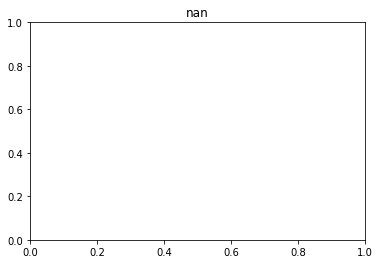

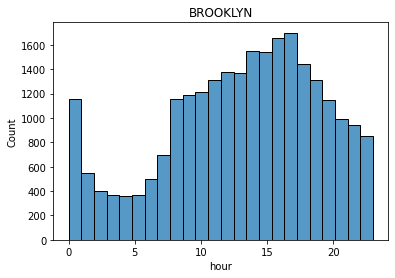

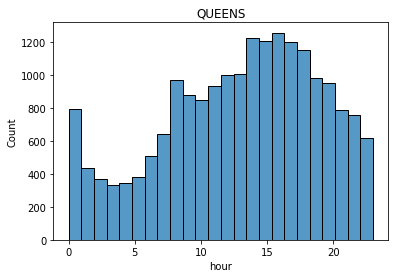

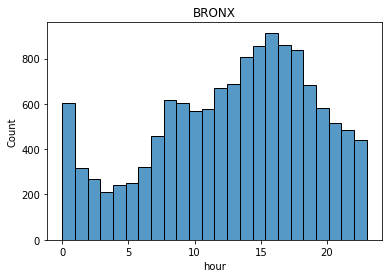

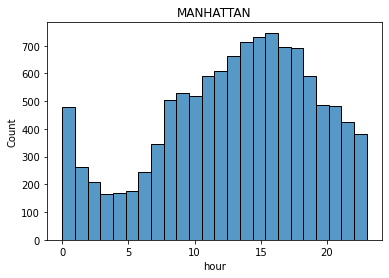

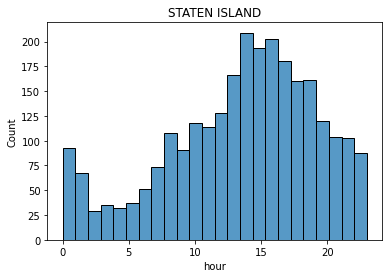

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

nyc_crash["hour"] = [x.split(":")[0] for x in nyc_crash["CRASH TIME"]]
nyc_crash["hour"] = [int(x) for x in nyc_crash["hour"]]

for borough in nyc_crash["BOROUGH"].unique():
    temp = nyc_crash.loc[nyc_crash["BOROUGH"] == borough]
    sns.histplot(x = 'hour', bins = 24, data = temp).set(title = borough)
    plt.show()


It appears that the most crashes happen around 3pm, and the least crashes around 3am.

In [103]:
nyc_crash["num_injured"] = nyc_crash["NUMBER OF PEDESTRIANS INJURED"]
nyc_crash["num_injured"] += nyc_crash["NUMBER OF CYCLIST INJURED"]
nyc_crash["num_injured"] += nyc_crash["NUMBER OF MOTORIST INJURED"]

def injury(row):
    if row["num_injured"] >= 1:
        val = 1
    else:
        val = 0
    return val

nyc_crash['injury'] = nyc_crash.apply(injury, axis = 1)

tab_injury = pd.crosstab(nyc_crash["injury"], nyc_crash["BOROUGH"])
tab_injury

BOROUGH,BRONX,BROOKLYN,MANHATTAN,QUEENS,STATEN ISLAND
injury,,,,,
0,9317,16929,7764,13489,1872
1,4065,8225,3654,6067,792


In [104]:
nyc_crash["num_killed"] = nyc_crash["NUMBER OF PEDESTRIANS KILLED"]
nyc_crash["num_killed"] += nyc_crash["NUMBER OF CYCLIST KILLED"]
nyc_crash["num_killed"] += nyc_crash["NUMBER OF MOTORIST KILLED"]

def death(row):
    if row["num_killed"] >= 1:
        val = 1
    else:
        val = 0
    return val

nyc_crash['death'] = nyc_crash.apply(death, axis = 1)

tab_death = pd.crosstab(nyc_crash["death"], nyc_crash["BOROUGH"])
tab_death

BOROUGH,BRONX,BROOKLYN,MANHATTAN,QUEENS,STATEN ISLAND
death,,,,,
0,13363,25104,11394,19526,2659
1,19,50,24,30,5


In [4]:
def seasons(row):
    if row['CRASH DATE'] < "03/20/2021":
        val = "Winter"
    elif row['CRASH DATE'] < "06/21/2021":
        val = "Spring"
    elif row['CRASH DATE'] < "09/23/2021":
        val = "Summer"
    elif row['CRASH DATE'] < "12/21/2021":
        val = "Autumn"
    else:
        val = "Winter"
    return val

nyc_crash['Season'] = nyc_crash.apply(seasons, axis = 1)
nyc_crash['Season'].value_counts()

Summer    30653
Spring    29379
Autumn    28249
Winter    22201
Name: Season, dtype: int64

# Does season affect crash time?

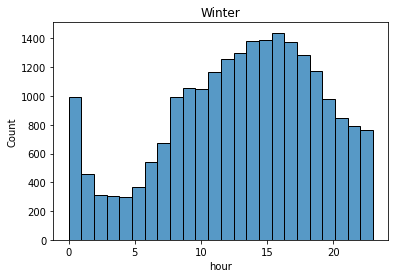

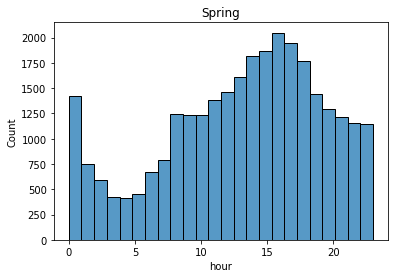

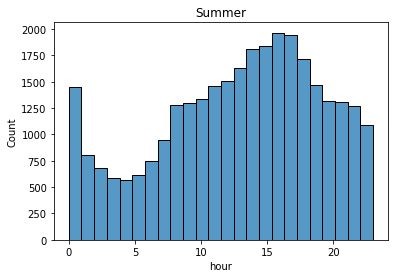

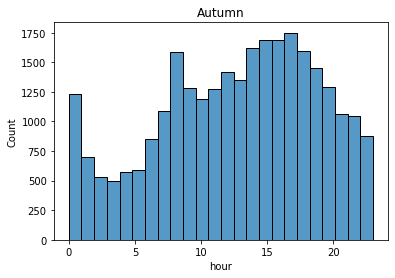

In [5]:
for season in nyc_crash["Season"].unique():
    temp = nyc_crash.loc[nyc_crash["Season"] == season]
    sns.histplot(x = 'hour', bins = 24, data = temp).set(title = season)
    plt.show()

In [6]:
nyc_crash["CONTRIBUTING FACTOR VEHICLE 1"] = nyc_crash["CONTRIBUTING FACTOR VEHICLE 1"].fillna('Other')
df = nyc_crash["CONTRIBUTING FACTOR VEHICLE 1"].value_counts()

def cfv1_100(row):
    if df[row['CONTRIBUTING FACTOR VEHICLE 1']] > 100:
        val = row['CONTRIBUTING FACTOR VEHICLE 1']
    else:
        val = "Other"
    return val

nyc_crash['cfv1_100'] = nyc_crash.apply(cfv1_100, axis = 1)

tab = pd.crosstab(nyc_crash["cfv1_100"], nyc_crash["num_injured"].sort_values(ascending=False))
tab

num_injured,0,1,2,3,4,5,6,7,8,9,10,11,14,16,17,18
cfv1_100,,,,,,,,,,,,,,,,
Aggressive Driving/Road Rage,537,219,54,21,6,5,1,2,0,0,1,0,0,0,0,0
Alcohol Involvement,1145,386,118,48,13,5,3,1,1,0,0,0,0,0,0,0
Backing Unsafely,2909,537,51,5,5,3,1,0,0,0,0,0,0,0,0,0
Brakes Defective,239,139,33,17,7,2,0,0,0,0,0,0,0,0,0,0
Driver Inattention/Distraction,17215,7280,1340,434,140,56,17,7,4,1,1,0,0,0,0,0
Driver Inexperience,1476,522,128,42,9,3,2,0,0,1,0,0,0,1,0,1
Driverless/Runaway Vehicle,91,23,3,0,0,0,0,0,0,0,0,0,0,0,0,0
Drugs (illegal),52,50,4,9,0,0,1,0,0,0,0,0,0,0,0,0
Failure to Keep Right,80,33,6,2,2,0,0,0,0,0,0,0,0,0,0,0


# How does borough effect injury ratio?

In [17]:
tab_injury = pd.crosstab(nyc_crash["injury"], nyc_crash["BOROUGH"])
tab_injury

BOROUGH,BRONX,BROOKLYN,MANHATTAN,QUEENS,STATEN ISLAND
injury,,,,,
0,9317,16929,7764,13489,1872
1,4065,8225,3654,6067,792


# What's the number of vehicles per crash in each borough?

In [8]:
nyc_crash["CONTRIBUTING FACTOR VEHICLE 2"] = nyc_crash["CONTRIBUTING FACTOR VEHICLE 2"].fillna('NaN')
nyc_crash["CONTRIBUTING FACTOR VEHICLE 3"] = nyc_crash["CONTRIBUTING FACTOR VEHICLE 3"].fillna('NaN')
nyc_crash["CONTRIBUTING FACTOR VEHICLE 4"] = nyc_crash["CONTRIBUTING FACTOR VEHICLE 4"].fillna('NaN')
nyc_crash["CONTRIBUTING FACTOR VEHICLE 5"] = nyc_crash["CONTRIBUTING FACTOR VEHICLE 5"].fillna('NaN')

def number_of_vehicles(row):
    if row["CONTRIBUTING FACTOR VEHICLE 5"] != 'NaN':
        val = 5
    elif row["CONTRIBUTING FACTOR VEHICLE 4"] != 'NaN':
        val = 4
    elif row["CONTRIBUTING FACTOR VEHICLE 3"] != 'NaN':
        val = 3
    elif row["CONTRIBUTING FACTOR VEHICLE 2"] != 'NaN':
        val = 2
    elif row["CONTRIBUTING FACTOR VEHICLE 1"] != 'NaN':
        val = 1
    return val

nyc_crash['num_vehicles'] = nyc_crash.apply(number_of_vehicles, axis = 1)

tab = pd.crosstab(nyc_crash["BOROUGH"], nyc_crash["num_vehicles"], normalize='index')
tab

num_vehicles,1,2,3,4,5
BOROUGH,,,,,
BRONX,0.283142,0.628008,0.062846,0.017411,0.008594
BROOKLYN,0.231136,0.664666,0.070963,0.021508,0.011728
MANHATTAN,0.245402,0.700473,0.040638,0.009284,0.004204
QUEENS,0.223563,0.669820,0.077061,0.020505,0.009051
STATEN ISLAND,0.251502,0.656156,0.074700,0.014264,0.003378


# Model to Predict if someone was injured or not

In [9]:
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix

In [10]:
def timeframes(x):
    if x <= 5:
        return 1
    elif x > 5 and x <= 11:
        return 2
    elif x > 11 and x <= 17:
        return 3
    else:
        return 4
    

## Take crash hours and put them into specifc intervals
nyc_crash['timeframe'] = nyc_crash['hour'].apply(timeframes)
nyc_crash['timeframe'] = nyc_crash['timeframe'].astype('category')

feature_cols = nyc_crash[['num_vehicles', 'Season','timeframe', 'BOROUGH', 'cfv1_100']]
features = pd.get_dummies(feature_cols)
features.head()



,num_vehicles,Season_Autumn,Season_Spring,Season_Summer,Season_Winter,timeframe_1,timeframe_2,timeframe_3,timeframe_4,BOROUGH_BRONX,...,cfv1_100_Pedestrian/Bicyclist/Other Pedestrian Error/Confusion,cfv1_100_Reaction to Uninvolved Vehicle,cfv1_100_Steering Failure,cfv1_100_Tire Failure/Inadequate,cfv1_100_Traffic Control Disregarded,cfv1_100_Turning Improperly,cfv1_100_Unsafe Lane Changing,cfv1_100_Unsafe Speed,cfv1_100_Unspecified,cfv1_100_View Obstructed/Limited
0,2,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [11]:
y = nyc_crash.injury

x_train, x_test, y_train, y_test = train_test_split(features, y, 
                                                    test_size = 0.2, 
                                                    random_state = 42)

rfclf = RandomForestClassifier(n_estimators = 100, random_state = 3131)
rfclf = rfclf.fit(x_train, y_train)

y_pred = rfclf.predict(x_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.6946191790740824
[[13508  1274]
 [ 5474  1841]]


In [12]:
for i in range (1, 11):
    rfclf = RandomForestClassifier(n_estimators = 100, random_state = 42, max_depth = i)
    rfclf = rfclf.fit(x_train, y_train)
    y_pred = rfclf.predict(x_test)
    print("Accuracy for Forest with Max Depth {i}:".format(i = i), 
          metrics.accuracy_score(y_test, y_pred))

Accuracy for Forest with Max Depth 1: 0.6689595872742906
Accuracy for Forest with Max Depth 2: 0.6689595872742906
Accuracy for Forest with Max Depth 3: 0.6689595872742906
Accuracy for Forest with Max Depth 4: 0.6840747612798117
Accuracy for Forest with Max Depth 5: 0.6852966466036113
Accuracy for Forest with Max Depth 6: 0.686518531927411
Accuracy for Forest with Max Depth 7: 0.688555007467077
Accuracy for Forest with Max Depth 8: 0.6893243426709508
Accuracy for Forest with Max Depth 9: 0.6890980676109879
Accuracy for Forest with Max Depth 10: 0.6933520387382902


Text(0.5, 0, 'Relative Importance')

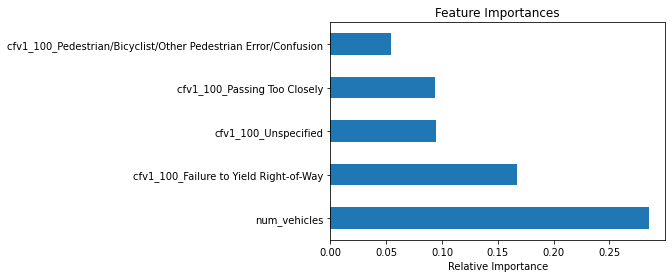

In [13]:
feat_importances = pd.Series(rfclf.feature_importances_, index=features.columns)
feat_importances.nlargest(5).plot(kind='barh')
plt.title('Feature Importances')
plt.xlabel('Relative Importance')

<AxesSubplot:xlabel='injury', ylabel='BOROUGH'>

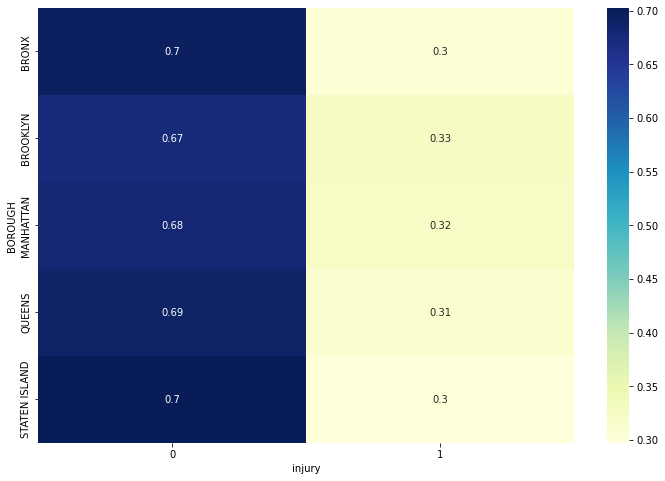

In [14]:
tab_perc = pd.crosstab(nyc_crash["BOROUGH"], nyc_crash["injury"], normalize = 'index')

plt.figure(figsize=(12,8)) 
sns.heatmap(tab_perc, annot=True, cmap="YlGnBu")

# A Chi-Squared regession on injuries by borough

In [107]:
import scipy.stats as stats
from scipy.stats import chisquare

tot_inj = tab_injury["BRONX"][0] + 16929 + 7764 + 13489 + 1872
tot_crash = 13382 + 25154 + 11418 + 19556 + 2864

bronx_crash_perc = 13382 / tot_crash
exp_bronx = round(tot_inj * bronx_crash_perc)

brook_crash_perc = 25154 / tot_crash
exp_brook = round(tot_inj * brook_crash_perc)

manhat_crash_perc = 11418 / tot_crash
exp_manhat = round(tot_inj * manhat_crash_perc)

queens_crash_perc = 19556 / tot_crash
exp_queens = round(tot_inj * queens_crash_perc)

staten_crash_perc = 2864 / tot_crash
exp_staten = round(tot_inj * staten_crash_perc)

chisquare([9317, 16929, 7764, 13489, 1872], f_exp=[exp_bronx, exp_brook, exp_manhat, exp_queens, exp_staten])

49371


Power_divergenceResult(statistic=12.140178772618974, pvalue=0.01633874066119707)

In [102]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn import metrics

feature_cols = nyc_crash[['num_vehicles', 'Season','timeframe', 'BOROUGH', 'cfv1_100']]
features = pd.get_dummies(feature_cols)

x_train, x_test, y_train, y_test = train_test_split(features, nyc_crash["injury"], test_size = 0.3, random_state=10)

clf = svm.SVC(kernel = 'linear')
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)

print('Accuracy:', metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6891537185095791


BOROUGH,BRONX,BROOKLYN,MANHATTAN,QUEENS,STATEN ISLAND
death,,,,,
0,13363,25104,11394,19526,2659
1,19,50,24,30,5
